## Course 1: Custom models, layers, and loss functions

In [1]:
import tensorflow as tf
tf.__version__

'2.4.1'

### Multiple Outputs

###### Build branching model

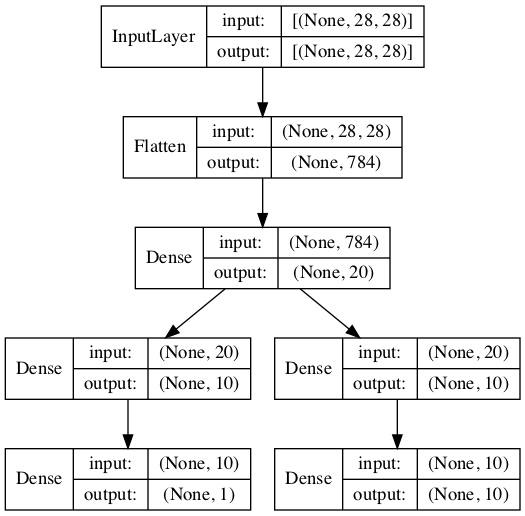

In [20]:
def build_branch_model():

    inputs = layers.Input(shape=(28,28))
    flatten = layers.Flatten()(inputs)
    dense = layers.Dense(20, activation='relu')(flatten)
    
    branch_1 = layers.Dense(10, activation='relu')(dense)
    branch_2 = layers.Dense(10, activation='relu')(dense)    
    
    output_1 = layers.Dense(1)(branch_1)
    output_2 = layers.Dense(10, activation='sigmoid')(branch_2)

    outputs = [output_1, output_2]

    model = tf.keras.Model(inputs, outputs)
    
    return model

branch_model = build_branch_model()
plot_model(branch_model, show_shapes=True, show_layer_names=False)

###### Get energy efficiency dataset from UCI

In [35]:
import numpy as np
import pandas as pd

# Energy efficiency dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"

data = pd.read_excel(url)

def format_outputs(df):
    y1 = df.pop('Y1').values
    y2 = df.pop('Y2').values
    return y1, y2

columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']

input_data = data[columns]
output_data = data[['Y1','Y2']]

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, test_size=.1)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

y_train = format_outputs(y_train)
y_test = format_outputs(y_test)

###### Train model with two target values

In [38]:
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

tf.keras.backend.clear_session()

def build_model():
    
    inputs = layers.Input(shape=(len(columns),))
    dense = layers.Dense(40, activation='relu')(inputs)
    
    branch_1 = layers.Dense(20, activation='relu')(dense)
    branch_2 = layers.Dense(20, activation='relu')(dense)    
    
    y1_output = layers.Dense(1, name='y1_output')(branch_1)
    y2_output = layers.Dense(1, name='y2_output')(branch_2)

    model = tf.keras.Model(inputs, [y1_output, y2_output])
    
    return model

model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 40)           360         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 20)           820         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 20)           820         dense[0][0]                      
______________________________________________________________________________________________

In [43]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=.001),
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

In [49]:
history = model.fit(X_train, y_train, 
                    batch_size=16, epochs=200,
                    validation_data=(X_test, y_test), verbose=0)

###### Visualize model performance

In [52]:
pd.DataFrame(history.history).columns

Index(['loss', 'y1_output_loss', 'y2_output_loss',
       'y1_output_root_mean_squared_error',
       'y2_output_root_mean_squared_error', 'val_loss', 'val_y1_output_loss',
       'val_y2_output_loss', 'val_y1_output_root_mean_squared_error',
       'val_y2_output_root_mean_squared_error'],
      dtype='object')

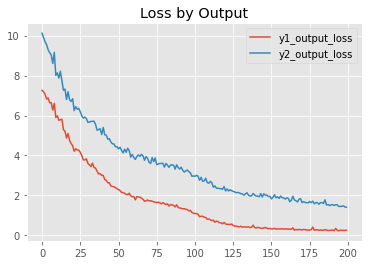

In [62]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.style.use('ggplot')
    hist = pd.DataFrame(history.history)
    hist[['y1_output_loss','y2_output_loss']].plot(title='Loss by Output')
    
plot_loss(history)

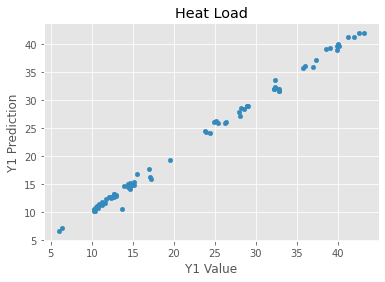

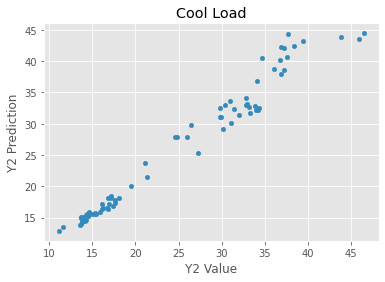

In [93]:
def plot_results(pred):
    
    y1_test, y2_test = y_test
    y1_pred = [x[0] for x in y_pred[0].tolist()]
    y2_pred = [x[0] for x in y_pred[1].tolist()]
    df = pd.DataFrame({'Y1 Value': y1_test, 'Y2 Value': y2_test,
                       'Y1 Prediction': y1_pred, 'Y2 Prediction': y2_pred})    
    df.plot.scatter(*['Y1 Value', 'Y1 Prediction'], title='Heat Load')
    df.plot.scatter(*['Y2 Value', 'Y2 Prediction'], title='Cool Load')


y_pred = model.predict(X_test)
plot_results(y_pred)

### Multiple Inputs

##### Siamese Network for Fashion MNIST

Given two image tensors $x_i$ and $x_j$ with classes $y_i$ and $y_j$,
we can train a *siamese network* that takes in image pairs and outputs their similarity.

The inputs/targets used to train this network are $X$ and $Y$, 

Where $X = (x_i, x_j) \mid x_i,x_j \in Images \text{ , and  }Y = \begin{cases} 0 &\mbox{if } y_i\neq y_j \\
1 & \mbox{if } y_i \equiv y_j \end{cases} \ $



###### Base network

In this notebook, we use a base network $f_b: x_i \rightarrow v_i$ 

The number of nodes in the final layer of $f_b$ determines the dimensionality
of $v$

(In our case, $v\in\mathbb{R}^{32}$ since the final layer is `Dense(32)`)


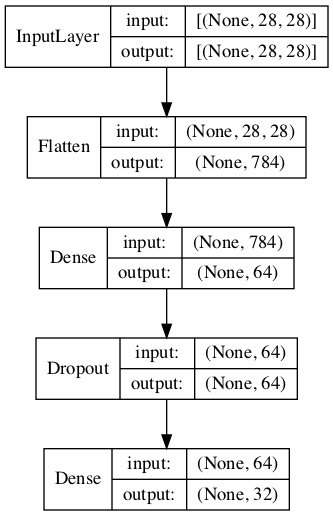

In [147]:
output_shape = 32

def initialize_base_network():
    
    input = layers.Input(shape=(28,28))
    x = layers.Flatten()(input)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(output_shape, activation='relu')(x)
    
    model = tf.keras.Model(input, x)
    return model

plot_model(initialize_base_network(), show_layer_names=False, show_shapes=True)

######  Siamese network



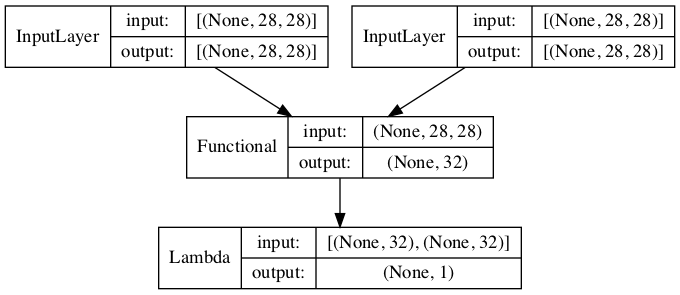

In [145]:
from keras import backend as K

def euclidean_distance(vectors):
    x, y = vectors
    sum_of_squared_difference = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_of_squared_difference, K.epsilon()))

def build_siamese_network_from_base():

    input_a = layers.Input(shape=(28,28))
    input_b = layers.Input(shape=(28,28))
    
    base_network = initialize_base_network()

    output_a = base_network(input_a)
    output_b = base_network(input_b)
    
    output = layers.Lambda(euclidean_distance, output_shape=output_shape)([output_a, output_b])
    model = tf.keras.Model([input_a, input_b], output)
    
    return model


model = build_siamese_network_from_base()

plot_model(model, show_layer_names=False, show_shapes=True)

###### Contrastive loss function

The loss function $L$ used to update the weights in our model
is defined as follows

$\\ L_{contras} = (1 - Y)\dfrac12(D_W)^2 + (Y)\dfrac12max(0, D_W) $

The **distance** $D_W$ is a learnable metric used to compute the
disparity between $x_i, x_j$


In [377]:
def ContrastiveLoss(margin=1.0):
    def contrastive_loss(y_true, y_pred):
        pred_squared = K.square(y_pred)
        y_true = tf.cast(y_true, dtype=tf.float32)
        margin_squared = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * pred_squared + (1 - y_true) * margin_squared)
    return contrastive_loss

###### Prepare data

In [387]:
from tensorflow.keras.datasets import fashion_mnist

def create_dataset(dataset, ratio=.5):

    images, labels = dataset
    indices = np.arange(len(labels))
    original = np.stack([indices, labels], axis=1)
    shuffled = np.stack([indices, labels], axis=1)

    X, y = [], []

    # Get pairs of images w/ labels corresponding to their class similarity
    np.random.shuffle(shuffled)
    X.extend(np.stack([images, images[shuffled[:,0]]], axis=1))
    y.extend([int(u==v) for u, v in zip(labels, shuffled[:,1])])
    # Check if the class labels match for tuples of index/label pairs
    same_class = lambda tuples: tuples[0][1]==tuples[1][1]
    # While the classes are imbalanced (sum/len gives ratio for binary data)
    while sum(y) / len(y) < ratio:
        # Repeat process, adding only image pairs with matching classes
        np.random.shuffle(shuffled)
        image_pairs = [(data[index_label_pairs[0][0]], data[index_label_pairs[1][0]])
                       for index_label_pairs in filter(same_class, zip(original, shuffled))]
        X.extend(image_pairs)
        y.extend([1]*len(image_pairs))
    return np.array(X) / 255, np.array(y)

# Prepare train/test sets
train, test = fashion_mnist.load_data()
X_train, y_train = create_dataset(train)
X_test, y_test = create_dataset(test)

# This shuffles our data and gives us a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=.1, random_state=0)

X_train.shape

(97270, 2, 28, 28)

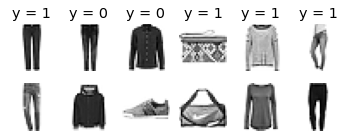

In [391]:
def plot_samples(n_cols = 6):
    
    fig, ax = plt.subplots(2, n_cols, figsize=(n_cols, 2))

    for i in range(n_cols):
        
        top, bottom = ax[0][i], ax[1][i]
        top.axis('off'), bottom.axis('off')
        top.set_title("y = {}".format(y_train[i]))
        

        image_1, image_2 = X_train[i]
        top.imshow(image_1, cmap='Greys')
        bottom.imshow(image_2, cmap='Greys')


plot_samples()

###### Train model

In [392]:
contrastive_loss = ContrastiveLoss(margin=1.0)
optimizer = tf.keras.optimizers.RMSprop()

# Compile with RMS Prop and contrastive loss
model.compile(optimizer=optimizer, loss=contrastive_loss)

# Fit to data
train_dataset = [X_train[:,0], X_train[:,1]]
validation_dataset = ([X_val[:,0], X_val[:,1]], y_val)


history = model.fit(train_dataset, y_train,
                    epochs=1, batch_size=16,
                    validation_data=validation_dataset)

6080/6080 [==============================] - 17s 3ms/step - loss: 0.1043 - val_loss: 0.0881


### 

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)